In [1]:
import json
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
import random
import itertools
from tensorflow import keras
from scipy import ndimage
from matplotlib.image import imread
from sklearn.preprocessing import OneHotEncoder

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
df = pd.read_csv('under_sampled.csv')
df.head()


,Unnamed: 0,Unnamed: 0.1,0,label
0,0,0,./IDC_regular_ps50_idx5/9320/0/9320_idx5_x1651...,0.0
1,1,1,./IDC_regular_ps50_idx5/8950/0/8950_idx5_x551_...,0.0
2,2,2,./IDC_regular_ps50_idx5/12898/0/12898_idx5_x16...,0.0
3,3,3,./IDC_regular_ps50_idx5/9081/0/9081_idx5_x1601...,0.0
4,4,4,./IDC_regular_ps50_idx5/16551/0/16551_idx5_x60...,0.0


In [3]:
images = df.iloc[:,2:3].values
labels = df.iloc[:,3:4].values

In [4]:
def parse_image(img, lbl):
    image = tf.io.read_file('../../' + img[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 50])
    return image, lbl

def show_image(img, lbl):
    plt.figure()
    plt.imshow(img)
#     plt.title(tf.strings.as_string()
    plt.axis('off')

In [5]:
split_0 = int(0.8*len(labels))
split_1 = int(0.1*len(labels))

In [6]:
print(split_0)

126057


In [7]:
data = tf.data.Dataset.from_tensor_slices((images, labels))
data = data.shuffle(len(labels), reshuffle_each_iteration=True)
data = data.map(parse_image)
train_data = data.take(split_0)
temp_data = data.skip(split_0)
val_data = temp_data.skip(split_1)
test_data = temp_data.take(split_1)

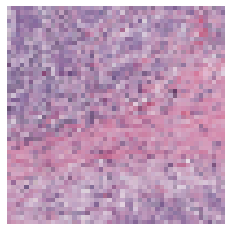

In [8]:
for image, label in train_data.take(1):
    show_image(image, label)

In [9]:
class Model(tf.keras.Model):

  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', bias_initializer='he_normal')
    self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', bias_initializer='he_normal')
    self.max0 = tf.keras.layers.MaxPool2D(2,2)
    self.conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")
    self.conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")
    self.conv5 = tf.keras.layers.Conv2D(128, 3, activation='relu')
    self.conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same")
    self.conv7 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same")
    self.conv8 = tf.keras.layers.Conv2D(256, 3, activation='relu')
    self.conv9 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same")
    self.conv10 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same")
    self.conv11 = tf.keras.layers.Conv2D(512, 3, activation='relu')
    self.conv12 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same")
    self.conv13 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same")
    # self.ave0 = tf.keras.layers.AveragePooling2D()
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(1000, activation='relu', use_bias= True)
    self.b1 = tf.keras.layers.BatchNormalization(trainable=True)
    # self.d2 = tf.keras.layers.Dense(4096, activation='relu')
    # self.b2 = tf.keras.layers.BatchNormalization(trainable=True)
    self.d2 = tf.keras.layers.Dense(1, activation='sigmoid',  use_bias= True)

  def call(self, x):
    x = tf.reshape(x, [-1, 50, 50, 3])
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.b1(x)
#     block_1 = self.max0(x)
    x = self.conv3(x)
#     x = self.conv4(x)
#     x = tf.keras.layers.add([x, block_1])
#     block_2 = self.conv5(x)
#     x = self.conv6(block_2)
#     x = self.conv7(x)
#     x = tf.keras.layers.add([x, block_2])
#     block_3 = self.conv8(x)
#     x = self.conv9(block_3)
#     x = self.conv10(x)
#     x = tf.keras.layers.add([x, block_3])
#     block_4 = self.conv11(x)
#     x = self.conv12(block_4)
#     x = self.conv13(x)
    x = self.max0(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return x
  
  def get_model():
    return Model(name='cnn')


model = Model()

In [17]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adadelta()
train_loss = tf.keras.metrics.Mean(name='t_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='t_accuracy')


test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

def train_step(images, labels):
      with tf.GradientTape() as tape:
        preds = model(images)
        loss = loss_function(labels, preds)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, preds)
#   print(train_accuracy.result())


def test_step(images, labels):
    preds = model(images)
#     labels = labels.numpy().decode('utf-8')
#     labels = float(labels)
    loss = loss_function(labels, preds)
    test_loss(loss)
    test_accuracy(labels, preds)


def val_step(images, labels):
  with tf.GradientTape() as tape:
    preds = model(images)
#     labels = labels.numpy().decode('utf-8')
#     labels = float(labels)
    loss = loss_function(labels, preds)
  val_loss(loss)
  val_accuracy(labels, preds)

epochs = 1

for epoch in range(epochs):
  for counter, (images, labels) in enumerate(train_data):
    train_step(images, labels)
    if counter % 12605 == 0 and counter!=0:
        print(f"Progress : {(counter/split_0)*100}, Training Accuracy : {train_accuracy.result()*100}")


  for val_images, val_labels in val_data:
    val_step(val_images, val_labels)

  print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()*100}, Validation Loss: {val_loss.result()}, Validation Accuracy: {val_accuracy.result()*100}')

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

Progress : 9.999444695653553, Training Accuracy : 73.96478271484375
Progress : 19.998889391307106, Training Accuracy : 76.3753890991211
Progress : 29.99833408696066, Training Accuracy : 77.50687408447266
Progress : 39.99777878261421, Training Accuracy : 78.12220764160156
Progress : 49.99722347826776, Training Accuracy : 78.54219055175781
Progress : 59.99666817392132, Training Accuracy : 78.79837799072266
Progress : 69.99611286957487, Training Accuracy : 78.92697143554688
Progress : 79.99555756522842, Training Accuracy : 79.1533203125
Progress : 89.99500226088199, Training Accuracy : 79.28265380859375
Progress : 99.99444695653553, Training Accuracy : 79.4368896484375
Epoch 1, Loss: 0.46084102988243103, Accuracy: 79.43708038330078, Validation Loss: 0.4366365969181061, Validation Accuracy: 80.86685943603516


In [18]:
model.save_weights('trained_model', save_format='tf')

In [10]:
model.load_weights('trained_model')

In [11]:
def load_image(img):
    image = tf.io.read_file(img)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 50])
    return image


In [15]:
image = load_image('../../' + images[-1][0])
pred = model(image)
print(pred.numpy())

[[0.8603688]]


In [16]:
cwd = os.getcwd()
print(cwd)

/home/vijal/Projects/ML/Breast-Cancer-Detection-Tutti-AI
